In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import os
%matplotlib inline

os.chdir("..")
total_df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

In [2]:
cols = list(total_df.columns)
gender_cols = [i for i in cols if i.startswith('gender')]
race_cols = [i for i in cols if i.startswith('race')]
print(gender_cols)
print(race_cols)

['gender_female', 'gender_male', 'gender_unknown']
['race_albino', 'race_american indian', 'race_asian', 'race_biracial', 'race_black', 'race_hispanic', 'race_unknown', 'race_white', 'race_white [hispanic or latino]', 'race_white/black [hispanic or latino]']


In [3]:
def is_binary(series, allow_na=False):
    '''
    Helper function for check_allcols_are_binary
    '''

    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]


def check_allcols_are_binary(df, start_string):
    ''' 
    Takes a OHE df and a string and checks if all columns starting with 
    that string are binary. If all columns are binary it returns the list of
    all column names, otherwise it returns a list of non_binary_cols.
    
    df: dataframe containing the OHE columns and data
    start_string: string that the OHE columns starts with (i.e. 'gender') 
    would return OHE columns ['gender_female', 'gender_male', 'gender_unknown']
    '''
    
    col_selection = [i for i in list(df.columns) if i.startswith(start_string)]
    non_binary_cols = []
    for column in col_selection:
        if is_binary(df[column]) != True:
            non_binary_cols.append(column)
    if non_binary_cols == []:
        print('All columns binary, returning complete column list')
        return col_selection
    else:
        print('Some columns not binary, returning list of non-binary columns')
        return non_binary_cols

In [4]:
# inpso from: https://stackoverflow.com/questions/38334296/reversing-
# one-hot-encoding-in-pandas
def undo_ohe_cols(df, col_subset):
    ''' 
    Takes a OHE df and a list of BINARY columns and undoes the OHE of those
    columns, returning a single series with original values in it.
    
    df: dataframe containing the OHE columns and data 
    col_subset: list of binary OHE columns on which you want to undo OHE
    '''

    df_subset = df[df.columns & col_subset]
    def undo_binary(row):
        for c in df_subset.columns:
            if row[c]==1:
                return c
    single_col = df_subset.apply(undo_binary, axis=1)
    return single_col

In [6]:
# check all cols are binary
race_cols = check_allcols_are_binary(total_df, 'race')

# since all binday, can undo-OHE
single_race_col = undo_ohe_cols(total_df, race_cols)

single_race_col.head()

All columns binary, returning complete column list


case_participant_id
260122253823                         race_black
272161011760                         race_black
864286527653                      race_hispanic
882206007016                         race_black
882242005211    race_white [hispanic or latino]
dtype: object

In [7]:
# check all cols are binary
gender_cols = check_allcols_are_binary(total_df, 'gender')

# since all binday, can undo-OHE
single_gender_col = undo_ohe_cols(total_df, gender_cols)

All columns binary, returning complete column list


### Looking at the distribution of charge_count in the whole population vs in sub-populations (by race). Here charge_count is already a numeric feature, so we don't have to undo one hot encoding. Seems like there could be some higher charge_counts for american indian and biracial, but these are small sample sizes.

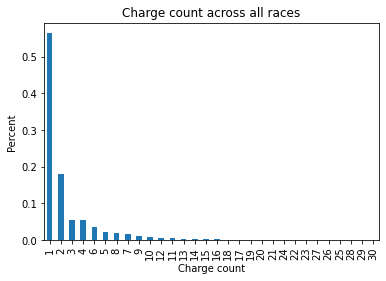

In [78]:
# all races
len(total_df['charge_count'].unique())
val_counts = total_df['charge_count'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('Charge count')
plt.title('Charge count across all races')

top20allraces = list(total_df['charge_count'].value_counts().nlargest(20).index)

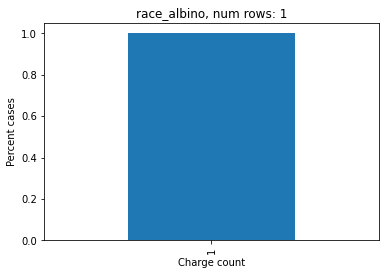

items in top 10 for this race that are not in top 20 items for all races:  set()


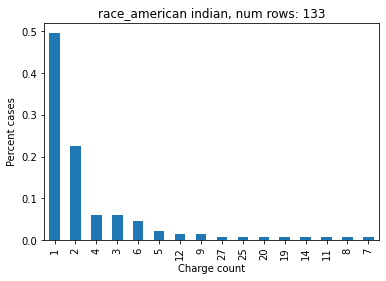

items in top 10 for this race that are not in top 20 items for all races:  {25, 27}


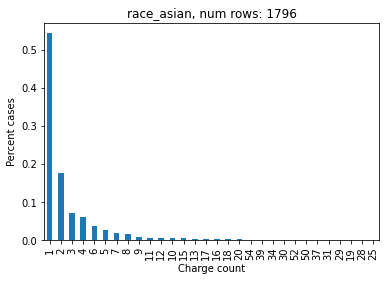

items in top 10 for this race that are not in top 20 items for all races:  set()


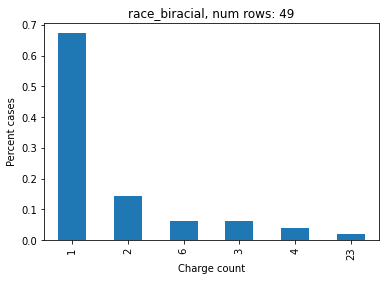

items in top 10 for this race that are not in top 20 items for all races:  {23}


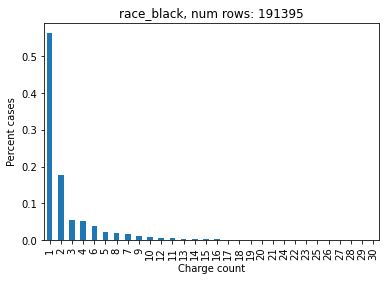

items in top 10 for this race that are not in top 20 items for all races:  set()


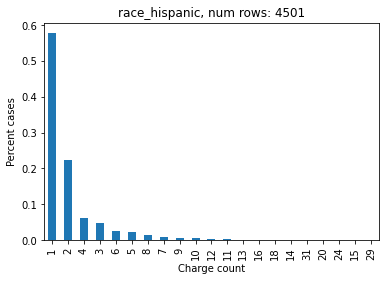

items in top 10 for this race that are not in top 20 items for all races:  set()


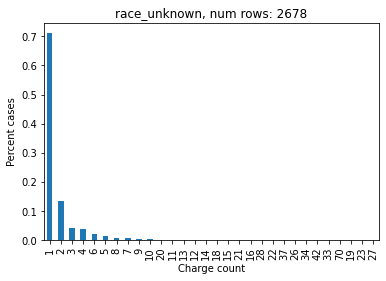

items in top 10 for this race that are not in top 20 items for all races:  set()


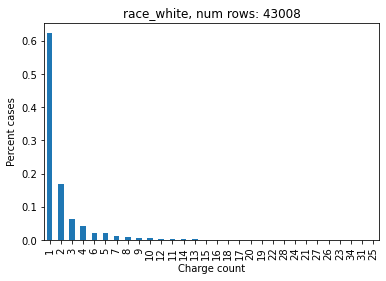

items in top 10 for this race that are not in top 20 items for all races:  set()


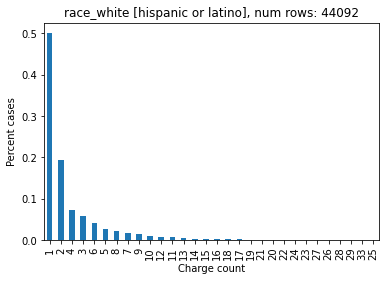

items in top 10 for this race that are not in top 20 items for all races:  set()


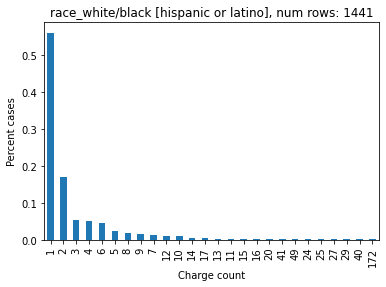

items in top 10 for this race that are not in top 20 items for all races:  set()


In [79]:
# looking at distributions for each race 
for col in race_cols:
    race_df = total_df[total_df[col] == 1]
    val_counts = race_df['charge_count'].value_counts(normalize=True).nlargest(30).plot(kind='bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Charge count')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    
    # print chg counts in top 10 that are not in top 20 across all races
    top10 = race_df['charge_count'].value_counts(normalize=True).nlargest(10).index
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Repeating same process but looking at offense_category distributions. Note, this (and all following colums were OHE so we have to undo the OHE first). We don't see any real differences across total population and sub populations except for american indian and biracial, which each have relatively small sample size. 

In [40]:
# looking at offense_category
off_cols = check_allcols_are_binary(total_df, 'offense')

# all binary, so undoing OHE
single_off_col = undo_ohe_cols(total_df, off_cols)

All columns binary, returning complete column list


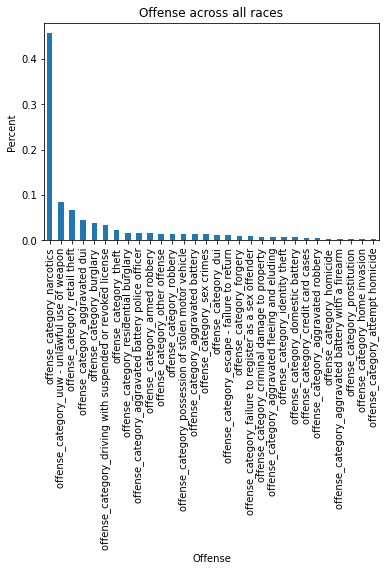

In [73]:
# looking at offense_category distribution for all races

# combining two series 
off_race_df = pd.concat([single_off_col.rename('offense'), single_race_col.rename('race')],
                        axis = 1)
val_counts = off_race_df['offense'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('Offense')
plt.title('Offense across all races')

# saving top 20 offense_category across all races
top20allraces = list(off_race_df['offense'].value_counts().nlargest(20).index)

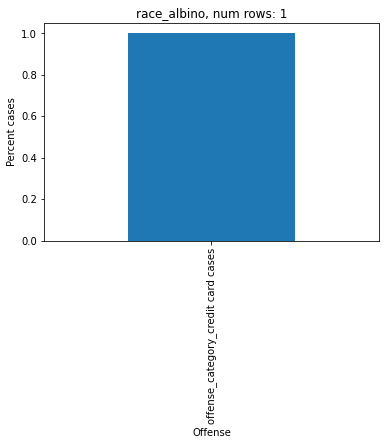

items in top 10 for this race that are not in top 20 items for all races:  {'offense_category_credit card cases'}


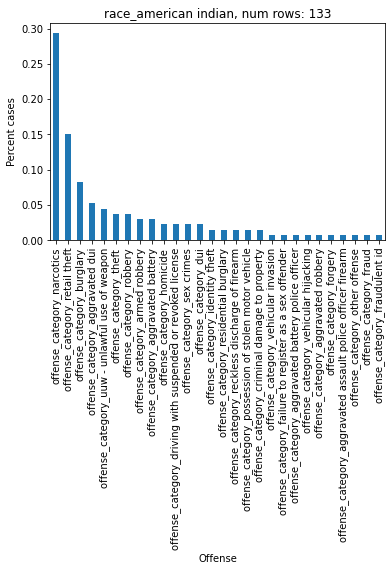

items in top 10 for this race that are not in top 20 items for all races:  {'offense_category_homicide'}


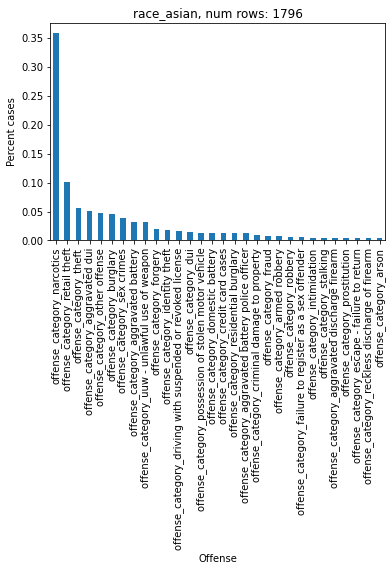

items in top 10 for this race that are not in top 20 items for all races:  set()


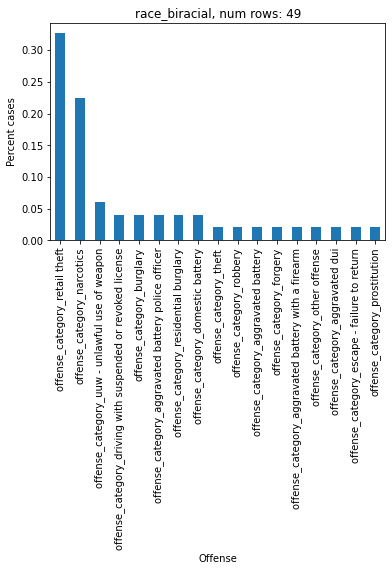

items in top 10 for this race that are not in top 20 items for all races:  {'offense_category_domestic battery', 'offense_category_aggravated battery with a firearm'}


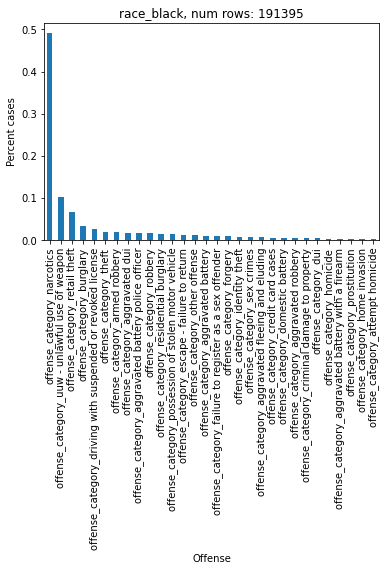

items in top 10 for this race that are not in top 20 items for all races:  set()


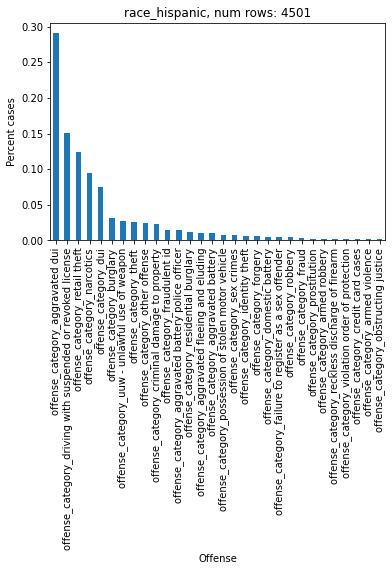

items in top 10 for this race that are not in top 20 items for all races:  set()


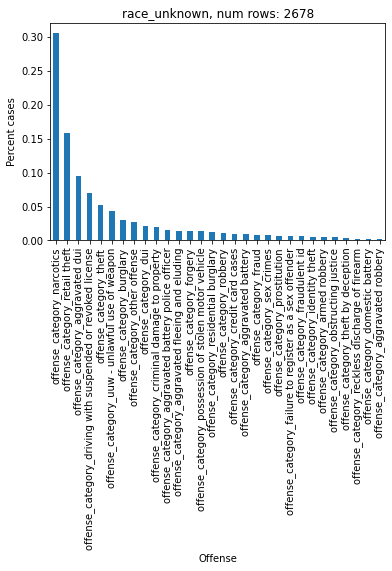

items in top 10 for this race that are not in top 20 items for all races:  set()


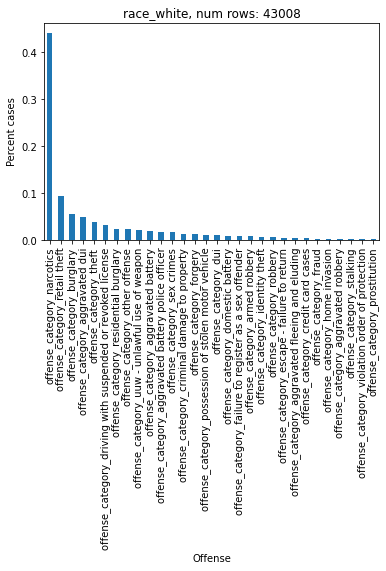

items in top 10 for this race that are not in top 20 items for all races:  set()


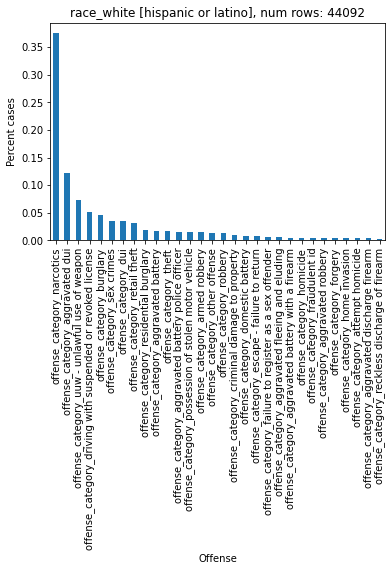

items in top 10 for this race that are not in top 20 items for all races:  set()


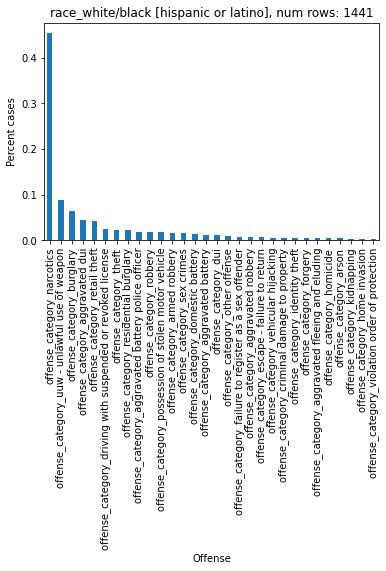

items in top 10 for this race that are not in top 20 items for all races:  set()


In [76]:
# looking at offense distributions for each race
for col in race_cols:
    race_df = off_race_df[off_race_df['race'] == col]
    val_counts = race_df['offense'].value_counts(normalize=True).nlargest(30).plot(kind='bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Offense')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    top10 = race_df['offense'].value_counts(normalize=True).nlargest(10).index
    
    # print categories in top 10 that are not in race top 20
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Repeating same process but looking at law_enforcement_agency distribution. See some pretty clear racial divides in neighborhoods and law_enforcement_agencys in the subpopulation graphs

In [104]:
# could be repeated for law_enforcement_agency, unit

# check all cols are binary
law_cols = check_allcols_are_binary(total_df, 'law')

# check all cols are binary
unit_cols = check_allcols_are_binary(total_df, 'unit')

# all binary so undoing OHE
single_law_col = undo_ohe_cols(total_df, law_cols)
single_unit_col = undo_ohe_cols(total_df, unit_cols)

All columns binary, returning complete column list
All columns binary, returning complete column list


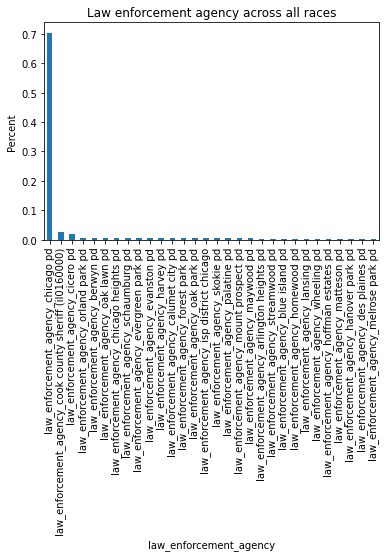

In [105]:
# looking at law_enforcement_agency distribution for all races

# combining two series 
law_race_df = pd.concat([single_law_col.rename('law_enforcement_agency'), 
                         single_race_col.rename('race')], axis = 1)
val_counts = law_race_df['law_enforcement_agency'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('law_enforcement_agency')
plt.title('Law enforcement agency across all races')

# saving top 20 law_enfrocement_agency across all races
top20allraces = list(law_race_df['law_enforcement_agency'].value_counts().nlargest(20).index)

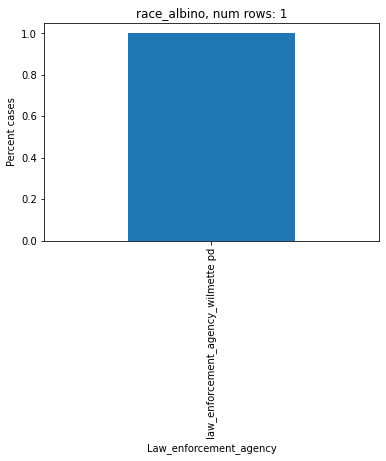

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_wilmette pd'}


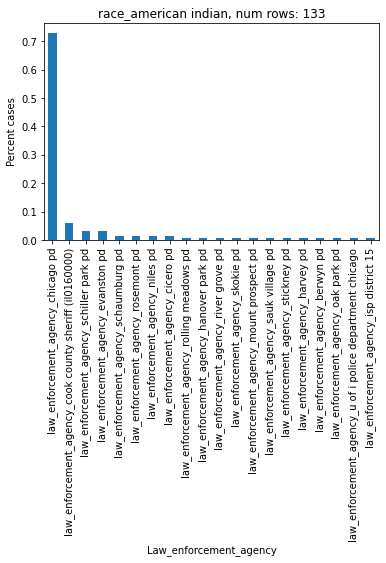

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_rosemont pd', 'law_enforcement_agency_schiller park pd', 'law_enforcement_agency_niles pd', 'law_enforcement_agency_u of i police department chicago'}


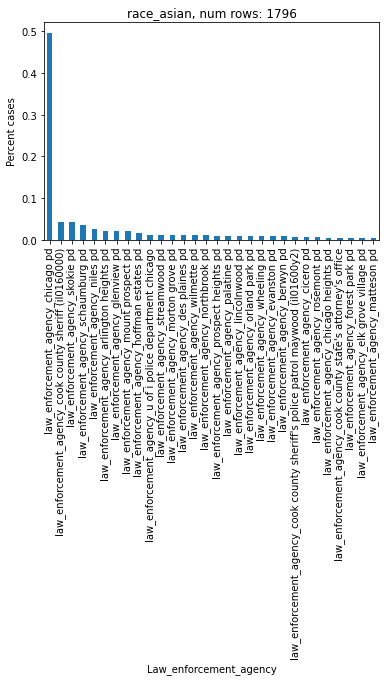

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hoffman estates pd', 'law_enforcement_agency_niles pd', 'law_enforcement_agency_u of i police department chicago', 'law_enforcement_agency_glenview pd'}


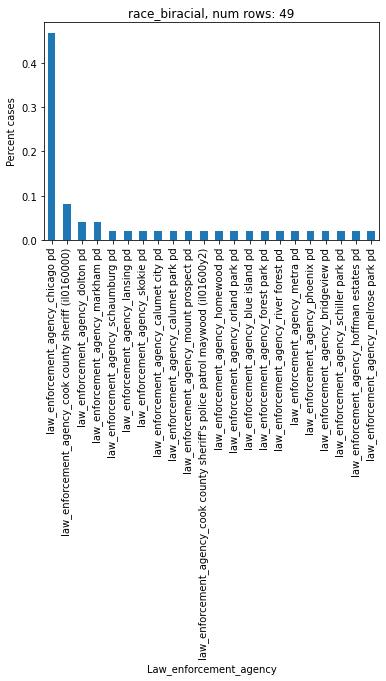

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_dolton pd', 'law_enforcement_agency_hoffman estates pd', 'law_enforcement_agency_markham pd', 'law_enforcement_agency_schiller park pd', 'law_enforcement_agency_metra pd', 'law_enforcement_agency_phoenix pd', 'law_enforcement_agency_bridgeview pd', 'law_enforcement_agency_river forest pd'}


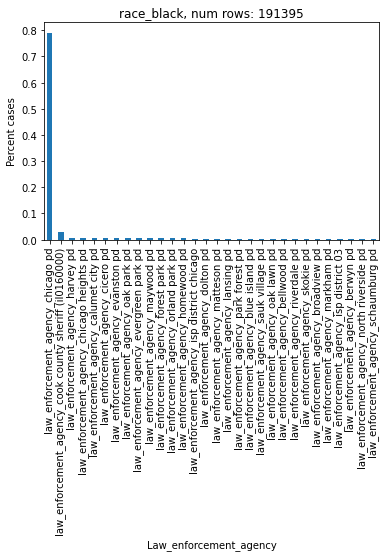

items in top 10 for this race that are not in top 20 items for all races:  set()


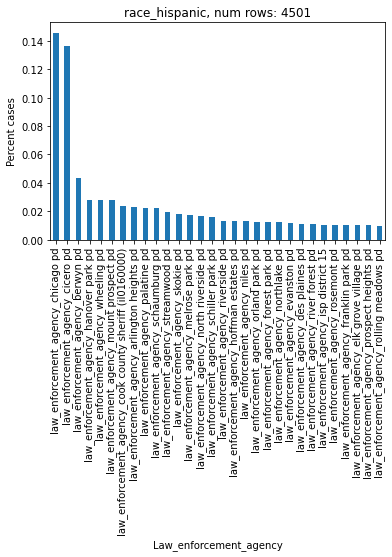

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hanover park pd', 'law_enforcement_agency_wheeling pd'}


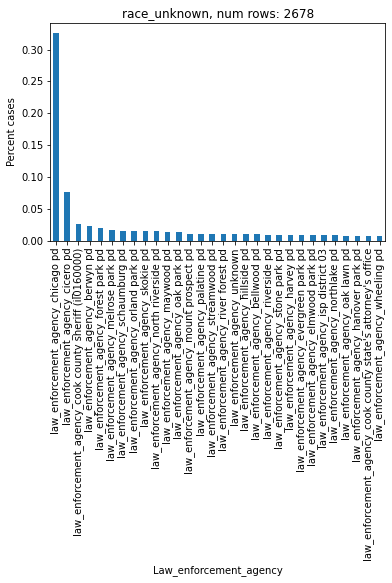

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_north riverside pd', 'law_enforcement_agency_melrose park pd'}


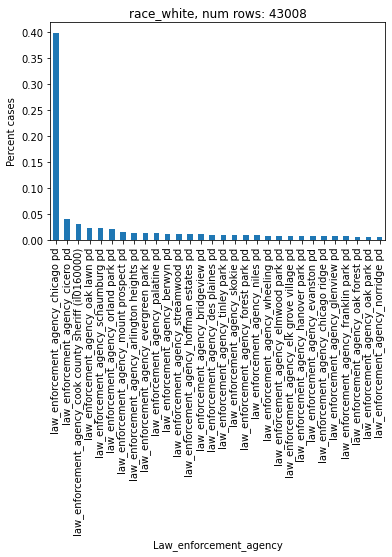

items in top 10 for this race that are not in top 20 items for all races:  set()


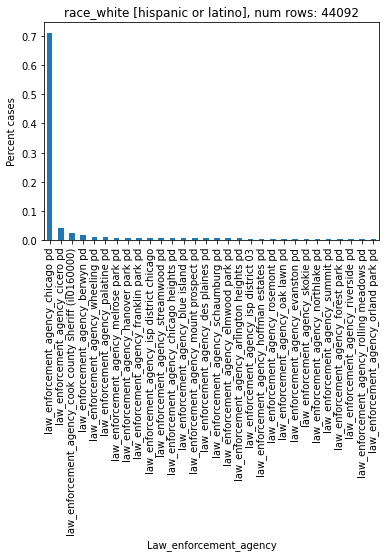

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hanover park pd', 'law_enforcement_agency_wheeling pd', 'law_enforcement_agency_franklin park pd', 'law_enforcement_agency_melrose park pd'}


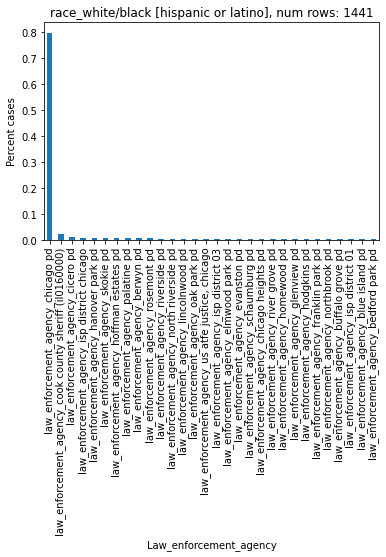

items in top 10 for this race that are not in top 20 items for all races:  {'law_enforcement_agency_hanover park pd', 'law_enforcement_agency_hoffman estates pd', 'law_enforcement_agency_rosemont pd'}


In [108]:
# looking at law_enforcement_agency distributions for each race
for col in race_cols:
    race_df = law_race_df[law_race_df['race'] == col]
    val_counts = race_df['law_enforcement_agency'].value_counts(normalize=
                                                               True).nlargest(30).plot(kind=
                                                                                       'bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Law_enforcement_agency')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    top10 = race_df['law_enforcement_agency'].value_counts(normalize=True).nlargest(10).index
    
    # print agencies in top 10 that are not in race top 20
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))

### Repeating same process but looking at unit distribution. Nothing super noticeable here.

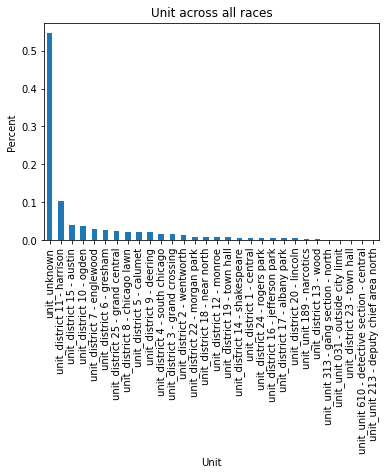

In [109]:
# looking at unit distribution for all races

# combining two series 
unit_race_df = pd.concat([single_unit_col.rename('unit'), 
                         single_race_col.rename('race')], axis = 1)
val_counts = unit_race_df['unit'].value_counts(normalize=
                                                   True).nlargest(30).plot(kind='bar')
plt.ylabel('Percent')
plt.xlabel('Unit')
plt.title('Unit across all races')

# saving top 20 unit across all races
top20allraces = list(unit_race_df['unit'].value_counts().nlargest(20).index)

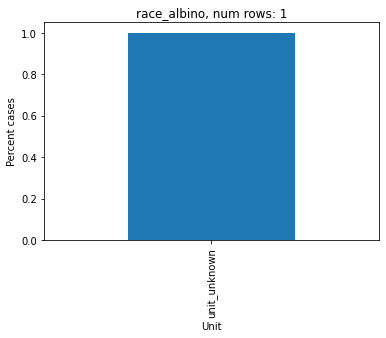

items in top 10 for this race that are not in top 20 items for all races:  set()


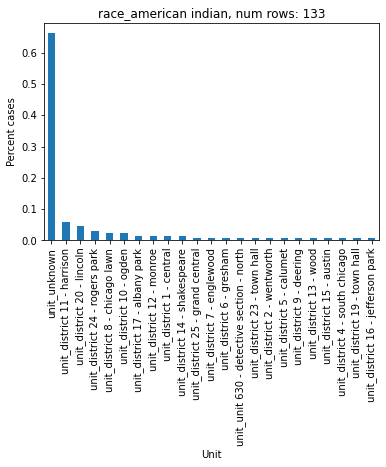

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 20 - lincoln', 'unit_district 17 - albany park'}


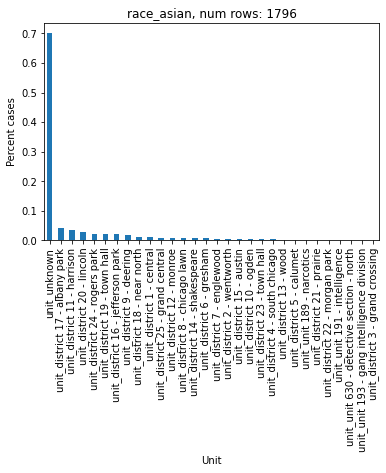

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 16 - jefferson park', 'unit_district 20 - lincoln', 'unit_district 17 - albany park'}


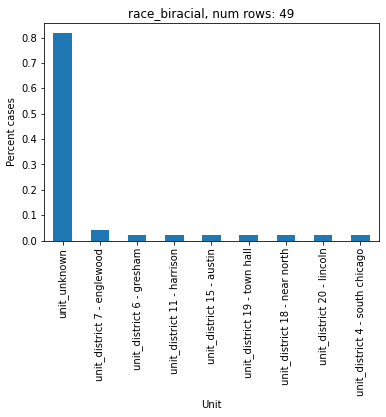

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 20 - lincoln'}


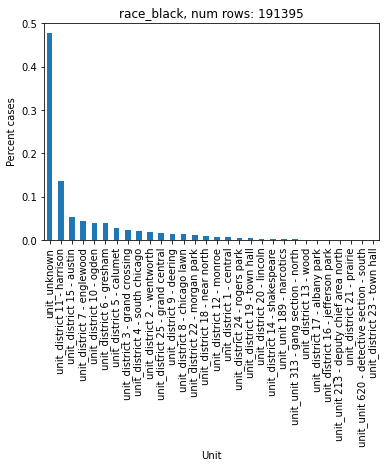

items in top 10 for this race that are not in top 20 items for all races:  set()


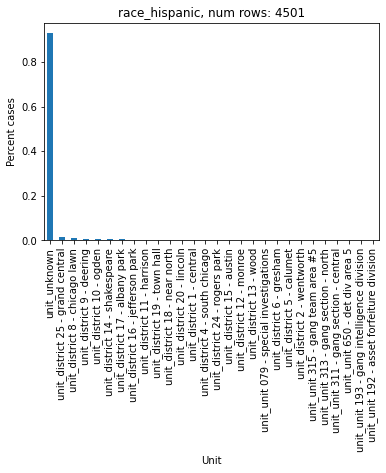

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 16 - jefferson park', 'unit_district 17 - albany park'}


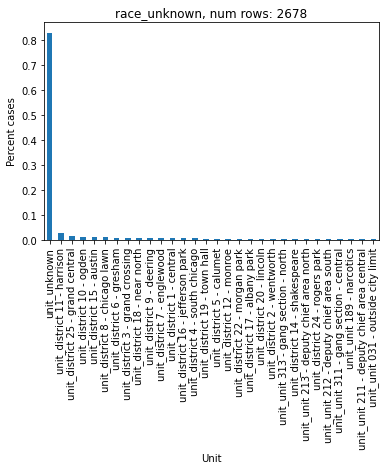

items in top 10 for this race that are not in top 20 items for all races:  set()


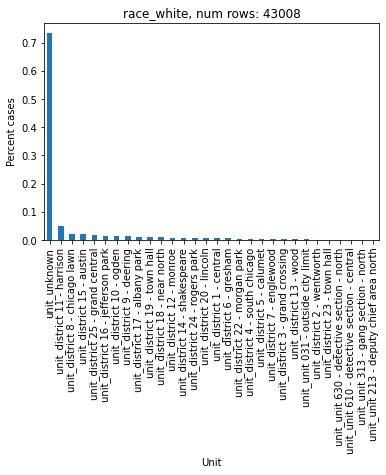

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 16 - jefferson park', 'unit_district 17 - albany park'}


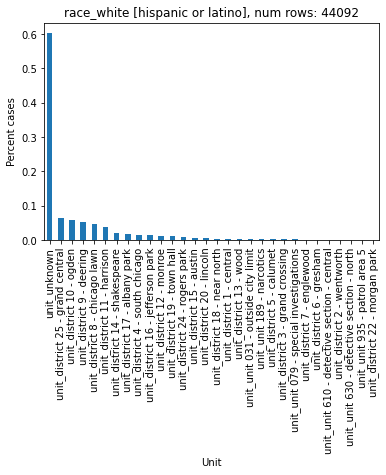

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 16 - jefferson park', 'unit_district 17 - albany park'}


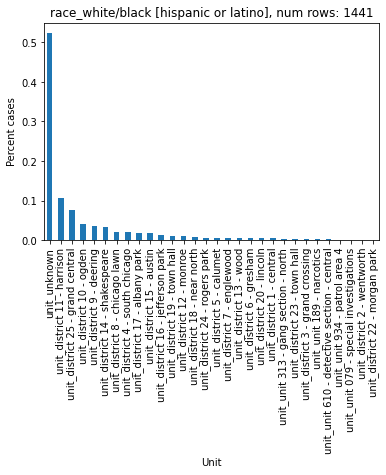

items in top 10 for this race that are not in top 20 items for all races:  {'unit_district 17 - albany park'}


In [112]:
# looking at unit distributions for each race
for col in race_cols:
    race_df = unit_race_df[law_race_df['race'] == col]
    val_counts = race_df['unit'].value_counts(normalize=True).nlargest(30).plot(kind='bar')
    title = str(col) + ', num rows: ' + str(len(race_df))
    plt.xlabel('Unit')
    plt.title(title)
    plt.ylabel('Percent cases')
    plt.show()
    top10 = race_df['unit'].value_counts(normalize=True).nlargest(10).index
    
    # print units in top 10 that are not in race top 20
    print('items in top 10 for this race that are not in top 20 items for all races: ',
          set(top10) - set(top20allraces))